In [48]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler
from sklearn.neighbors import KNeighborsClassifier

from helper import load_data, write_to_csv, set_sepcial_observation
import DataPreprocessor 
#from handcraft_logistic_regression import LogisticRegression

In [19]:
import importlib
importlib.reload(DataPreprocessor)

<module 'DataPreprocessor' from 'd:\\Coding\\NTU\\110-1\\EEML\\HW2\\DataPreprocessor.py'>

In [2]:
data_path = "./data/"
path_train = os.path.join(data_path, "train.csv")
path_test = os.path.join(data_path, "test.csv")
data_train, data_test = load_data(path_train, path_test)

In [8]:
DP = DataPreprocessor.DataPreprocessor()
X_train, y_train = DP.preprocess_train_data(data_train)
X_test= DP.preprocess_test_data(data_test)

(32561, 103)
(16281, 103)


/content/gdrive/MyDrive/EEML/HW2/DataPreprocessor.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cat["native_country"] = data_cat["native_country"].astype(pd.CategoricalDtype(categories=self.all_native_countries))


In [4]:
print(X_train.shape)
print(X_test.shape)

(32561, 108)
(16281, 108)


# Modeling

In [24]:
cond1 = (data_test["education_num"] == 1)
cond2 = (data_test["workclass"] == "Never-worked")
special_index = data_test[cond1 | cond2].index.tolist()

# All features
## Numerical
- robust scaling
## Categorical
- one-hot

## KNN


In [5]:
k_max = round(np.sqrt(X_train.shape[0]))
k_range = list(range(20, k_max, 3))
param_grid = {
    "n_neighbors": k_range,
    "weights": ["uniform", "distance"],
    "metric": ["euclidean", "manhattan"]
}

In [6]:
KNN = KNeighborsClassifier()
GS = GridSearchCV(KNN, 
    param_grid, 
    verbose = 1,
    cv = 5, n_jobs = -1).fit(X_train, y_train)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   59.3s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed: 11.6min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed: 20.9min
[Parallel(n_jobs=-1)]: Done 1080 out of 1080 | elapsed: 29.7min finished


In [10]:
GS.score(X_train, y_train)

0.9999692884125181

In [14]:
GS.best_estimator_

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='manhattan',
                     metric_params=None, n_jobs=None, n_neighbors=32, p=2,
                     weights='distance')

param_n_neighbors
20     0.798517
23     0.799008
26     0.799177
29     0.800152
32     0.799876
35     0.799929
38     0.799192
41     0.799162
44     0.798440
47     0.798263
50     0.797672
53     0.797557
56     0.796843
59     0.796666
62     0.796336
65     0.796144
68     0.795653
71     0.795215
74     0.794578
77     0.794301
80     0.793664
83     0.793334
86     0.792904
89     0.792651
92     0.792274
95     0.791998
98     0.791468
101    0.791253
104    0.790693
107    0.790347
110    0.789925
113    0.789710
116    0.789388
119    0.789104
122    0.788666
125    0.788466
128    0.787975
131    0.787576
134    0.787031
137    0.786754
140    0.786316
143    0.786094
146    0.785633
149    0.785395
152    0.784904
155    0.784681
158    0.784259
161    0.784113
164    0.783675
167    0.783476
170    0.783192
173    0.783046
176    0.782792
179    0.782554
Name: mean_test_score, dtype: float64


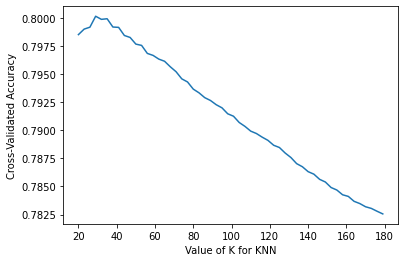

In [8]:
GS_result = pd.DataFrame(GS.cv_results_)
print(GS_result.groupby(["param_n_neighbors"])['mean_test_score'].mean())

k_idx = GS_result.groupby(["param_n_neighbors"])['mean_test_score'].mean().index
acc = GS_result.groupby(["param_n_neighbors"])['mean_test_score'].mean().values

plt.plot(k_idx, acc)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated Accuracy')
plt.show()

In [26]:
y_pred = GS.predict(X_test)
print(f"Before hard labeling, ratio of income >50K = {y_pred.sum() / y_pred.shape[0]}")
y_pred = set_sepcial_observation(y_pred, special_index)
print(f"After hard labeling, ratio of income >50K = {y_pred.sum() / y_pred.shape[0]}")

Before hard labeling, ratio of income >50K = 0.07579387015539586
After hard labeling, ratio of income >50K = 0.07573244886677723


In [27]:
#記得改名字
file_name = 'submission_1025_4.csv'
write_to_csv(y_pred, file_name)

## K-means

# Selected features
## Numerical
- robust scaling
## Categorical
- one-hot
- remove some features and categories

## KNN

In [66]:
k_max = round(np.sqrt(X_train.shape[0]))
k_range = list(range(20, k_max, 3))
param_grid = {
    "n_neighbors": k_range,
    "weights": ["uniform", "distance"],
    "metric": ["euclidean", "manhattan"]
}

In [67]:
KNN = KNeighborsClassifier()
GS = GridSearchCV(KNN, 
    param_grid, 
    verbose = 1,
    cv = 5)

In [68]:
GS.fit(X_train, y_train)

Fitting 5 folds for each of 56 candidates, totalling 280 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 280 out of 280 | elapsed: 15.2min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid={'metric': ['euclidean', 'manhattan'],
                         'n_neighbors': [25, 27, 29, 31, 33, 35, 37, 39, 41, 43,
                                         45, 47, 49, 51],
                         'weights': ['uniform', 'distance']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=1)

In [69]:
GS.score(X_train, y_train)

0.8689044088238009

In [72]:
GS.best_estimator_

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='manhattan',
                     metric_params=None, n_jobs=None, n_neighbors=35, p=2,
                     weights='uniform')

param_n_neighbors
25    0.858213
27    0.858175
29    0.858013
31    0.858136
33    0.858167
35    0.858321
37    0.858190
39    0.858121
41    0.858090
43    0.857859
45    0.858313
47    0.858344
49    0.858136
51    0.857959
Name: mean_test_score, dtype: float64


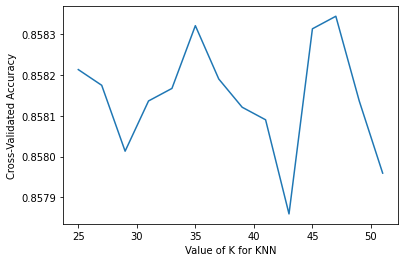

In [73]:
GS_result = pd.DataFrame(GS.cv_results_)
print(GS_result.groupby(["param_n_neighbors"])['mean_test_score'].mean())

k_idx = GS_result.groupby(["param_n_neighbors"])['mean_test_score'].mean().index
acc = GS_result.groupby(["param_n_neighbors"])['mean_test_score'].mean().values

plt.plot(k_idx, acc)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated Accuracy')
plt.show()

In [74]:
y_pred = GS.predict(X_test)
print(f"Before hard labeling, ratio of income >50K = {y_pred.sum() / y_pred.shape[0]}")
y_pred = set_sepcial_observation(y_pred, special_index)
print(f"After hard labeling, ratio of income >50K = {y_pred.sum() / y_pred.shape[0]}")

Before hard labeling, ratio of income >50K = 0.19783797064062403
After hard labeling, ratio of income >50K = 0.1977765493520054


In [ ]:
#記得改名字
file_name = 'submission_1025_3.csv'
write_to_csv(y_pred, file_name)

## K-means

# Selected featuers
- Only use numerical features
- no scaling

In [6]:
num_cols = ["age", "fnlwgt", "capital_gain", "capital_loss", "hours_per_week", "education_num"]
y_train = data_train["income"]
X_train_num = np.array(data_train[num_cols])
X_test_num = np.array(data_test[num_cols])

In [10]:
k_max = round(np.sqrt(X_train_num.shape[0]))
k_range = list(range(20, k_max, 3))
param_grid = {
    "n_neighbors": k_range,
    "weights": ["uniform", "distance"],
    "metric": ["euclidean", "manhattan"]
}

In [11]:
KNN = KNeighborsClassifier()
GS = GridSearchCV(KNN, 
    param_grid, 
    verbose = 1,
    cv = 5, n_jobs = -1).fit(X_train_num, y_train)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   17.7s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 1080 out of 1080 | elapsed:  6.5min finished


Training accuracy 0.8057184975891404
========== Best estimator is ==========
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='manhattan',
                     metric_params=None, n_jobs=None, n_neighbors=20, p=2,
                     weights='uniform')
========== CV Acc for each K ==========
param_n_neighbors
20     0.796528
23     0.797142
26     0.797442
29     0.798440
32     0.798033
35     0.798048
38     0.797365
41     0.797380
44     0.796774
47     0.796566
50     0.795998
53     0.795829
56     0.795215
59     0.795115
62     0.794724
65     0.794685
68     0.794148
71     0.793749
74     0.793081
77     0.792804
80     0.792159
83     0.791837
86     0.791453
89     0.791177
92     0.790762
95     0.790593
98     0.790117
101    0.789917
104    0.789395
107    0.789073
110    0.788628
113    0.788451
116    0.788075
119    0.787844
122    0.787437
125    0.787238
128    0.786800
131    0.786416
134    0.785817
137    0.785610
140    0.785172
143    0.784942
146  

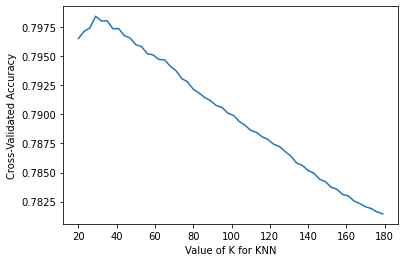

In [13]:
print(f"Training accuracy {GS.score(X_train_num, y_train)}")
print("="*10, "Best estimator is", "="*10)
print(GS.best_estimator_)

GS_result = pd.DataFrame(GS.cv_results_)
print("="*10, "CV Acc for each K", "="*10)
print(GS_result.groupby(["param_n_neighbors"])['mean_test_score'].mean())

k_idx = GS_result.groupby(["param_n_neighbors"])['mean_test_score'].mean().index
acc = GS_result.groupby(["param_n_neighbors"])['mean_test_score'].mean().values

plt.plot(k_idx, acc)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated Accuracy')
plt.show()

# Selected featuers
- Only use numerical features
- robust scaler

In [40]:
num_cols = ["age", "fnlwgt", "capital_gain", "capital_loss", "hours_per_week", "education_num"]
y_train = data_train["income"]
X_train_num = np.array(data_train[num_cols])
X_test_num = np.array(data_test[num_cols])

In [41]:
robust_scaler = RobustScaler()
X_train_num_scaled = robust_scaler.fit_transform(X_train_num)
X_test_num_scaled = robust_scaler.transform(X_test_num)

In [42]:
k_max = round(np.sqrt(X_train_num.shape[0]))
k_range = list(range(20, k_max, 3))
param_grid = {
    "n_neighbors": k_range,
    "weights": ["uniform", "distance"],
    "metric": ["euclidean", "manhattan"]
}

In [43]:
KNN = KNeighborsClassifier()
GS = GridSearchCV(KNN, 
    param_grid, 
    verbose = 1,
    cv = 5, n_jobs = -1).fit(X_train_num_scaled, y_train)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed: 14.9min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed: 27.3min
[Parallel(n_jobs=-1)]: Done 1080 out of 1080 | elapsed: 39.4min finished


Training accuracy 0.9987715365007217
========== Best estimator is ==========
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='euclidean',
                     metric_params=None, n_jobs=None, n_neighbors=170, p=2,
                     weights='distance')
========== CV Acc for each K ==========
param_n_neighbors
20     0.833705
23     0.834050
26     0.834641
29     0.834457
32     0.835033
35     0.835225
38     0.835110
41     0.835017
44     0.835340
47     0.835432
50     0.835724
53     0.835332
56     0.835486
59     0.835493
62     0.835378
65     0.835386
68     0.835424
71     0.835225
74     0.834841
77     0.834657
80     0.834971
83     0.835040
86     0.835332
89     0.835363
92     0.835263
95     0.835263
98     0.835286
101    0.835002
104    0.835470
107    0.835240
110    0.835294
113    0.835225
116    0.835371
119    0.835048
122    0.835394
125    0.835240
128    0.835424
131    0.834787
134    0.834841
137    0.834703
140    0.834472
143    0.834380
146

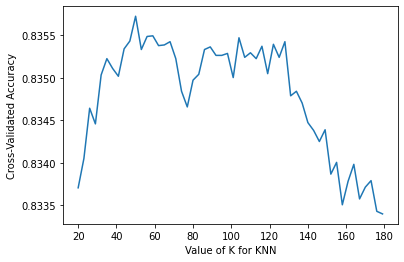

In [44]:
print(f"Training accuracy {GS.score(X_train_num_scaled, y_train)}")
print("="*10, "Best estimator is", "="*10)
print(GS.best_estimator_)

GS_result = pd.DataFrame(GS.cv_results_)
print("="*10, "CV Acc for each K", "="*10)
print(GS_result.groupby(["param_n_neighbors"])['mean_test_score'].mean())

k_idx = GS_result.groupby(["param_n_neighbors"])['mean_test_score'].mean().index
acc = GS_result.groupby(["param_n_neighbors"])['mean_test_score'].mean().values

plt.plot(k_idx, acc)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated Accuracy')
plt.show()

# Selected featuers
- Only use numerical features
- robust scaler (do not scale `education_num`)

In [29]:
num_cols = ["age", "fnlwgt", "capital_gain", "capital_loss", "hours_per_week"]
order_cat_cols = ["education_num"]
y_train = data_train["income"]

X_train_order = np.array(data_train[order_cat_cols])
X_train_num = np.array(data_train[num_cols])

X_test_order = np.array(data_test[order_cat_cols])
X_test_num = np.array(data_test[num_cols])

In [31]:
robust_scaler = RobustScaler()
X_train_num_scaled = robust_scaler.fit_transform(X_train_num)
X_test_num_scaled = robust_scaler.transform(X_test_num)

In [32]:
X_train = np.concatenate([X_train_order, X_train_num_scaled], axis = 1)
X_test = np.concatenate([X_test_order, X_test_num_scaled], axis = 1)

In [37]:
k_max = round(np.sqrt(X_train_num.shape[0]))
k_range = list(range(20, k_max, 3))
param_grid = {
    "n_neighbors": k_range,
    "weights": ["uniform", "distance"],
    "metric": ["euclidean", "manhattan"]
}

In [38]:
KNN = KNeighborsClassifier()
GS = GridSearchCV(KNN, 
    param_grid, 
    verbose = 1,
    cv = 5, n_jobs = -1).fit(X_train, y_train)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed: 15.2min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed: 27.6min
[Parallel(n_jobs=-1)]: Done 1080 out of 1080 | elapsed: 39.7min finished


Training accuracy 0.8481926230766869
========== Best estimator is ==========
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='manhattan',
                     metric_params=None, n_jobs=None, n_neighbors=26, p=2,
                     weights='uniform')
========== CV Acc for each K ==========
param_n_neighbors
20     0.833881
23     0.834127
26     0.835240
29     0.834994
32     0.835447
35     0.835440
38     0.835317
41     0.835248
44     0.835524
47     0.835501
50     0.835885
53     0.835463
56     0.835540
59     0.835563
62     0.835378
65     0.835194
68     0.834964
71     0.834802
74     0.834672
77     0.834357
80     0.834587
83     0.834680
86     0.834741
89     0.834818
92     0.834710
95     0.834795
98     0.834764
101    0.834618
104    0.834879
107    0.834841
110    0.834864
113    0.834795
116    0.834518
119    0.834380
122    0.834204
125    0.834196
128    0.834096
131    0.833735
134    0.833743
137    0.833789
140    0.833190
143    0.832921
146  

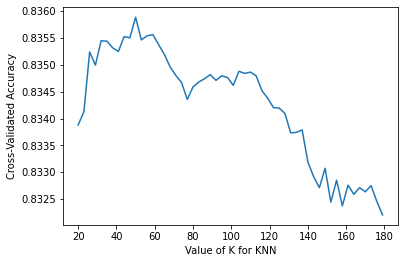

In [39]:
print(f"Training accuracy {GS.score(X_train, y_train)}")
print("="*10, "Best estimator is", "="*10)
print(GS.best_estimator_)

GS_result = pd.DataFrame(GS.cv_results_)
print("="*10, "CV Acc for each K", "="*10)
print(GS_result.groupby(["param_n_neighbors"])['mean_test_score'].mean())

k_idx = GS_result.groupby(["param_n_neighbors"])['mean_test_score'].mean().index
acc = GS_result.groupby(["param_n_neighbors"])['mean_test_score'].mean().values

plt.plot(k_idx, acc)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated Accuracy')
plt.show()

# Selected featuers
- Only use numerical features
- min max scaler (do not scale `education_num`)

In [62]:
num_cols = ["age", "fnlwgt", "capital_gain", "capital_loss", "hours_per_week"]
order_cat_cols = ["education_num"]
y_train = data_train["income"]

X_train_order = np.array(data_train[order_cat_cols])
X_train_num = np.array(data_train[num_cols])

X_test_order = np.array(data_test[order_cat_cols])
X_test_num = np.array(data_test[num_cols])

In [67]:
MMS = MinMaxScaler()
X_train_num_scaled = MMS.fit_transform(X_train_num)
X_test_num_scaled = MMS.transform(X_test_num)

In [68]:
X_train = np.concatenate([X_train_order, X_train_num_scaled], axis = 1)
X_test = np.concatenate([X_test_order, X_test_num_scaled], axis = 1)

In [69]:
k_max = round(np.sqrt(X_train_num.shape[0]))
k_range = list(range(20, k_max, 3))
param_grid = {
    "n_neighbors": k_range,
    "weights": ["uniform", "distance"],
    "metric": ["euclidean", "manhattan"]
}

In [70]:
KNN = KNeighborsClassifier()
GS = GridSearchCV(KNN, 
    param_grid, 
    verbose = 1,
    cv = 5, n_jobs = -1).fit(X_train, y_train)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   40.2s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  7.7min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed: 14.1min
[Parallel(n_jobs=-1)]: Done 1080 out of 1080 | elapsed: 20.5min finished


Training accuracy 0.8278308405761494
========== Best estimator is ==========
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='manhattan',
                     metric_params=None, n_jobs=None, n_neighbors=20, p=2,
                     weights='uniform')
========== CV Acc for each K ==========
param_n_neighbors
20     0.808406
23     0.809097
26     0.808790
29     0.808836
32     0.809097
35     0.809250
38     0.809005
41     0.808974
44     0.808613
47     0.808713
50     0.808590
53     0.808675
56     0.808429
59     0.808605
62     0.808083
65     0.808152
68     0.807669
71     0.807423
74     0.807131
77     0.807170
80     0.806847
83     0.806709
86     0.806141
89     0.806302
92     0.805757
95     0.805573
98     0.805365
101    0.805235
104    0.805112
107    0.804951
110    0.804513
113    0.804682
116    0.804513
119    0.804413
122    0.804275
125    0.804498
128    0.804421
131    0.804697
134    0.804383
137    0.804252
140    0.804229
143    0.804267
146  

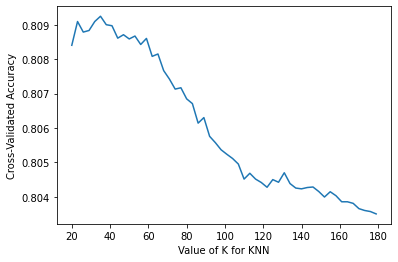

In [71]:
print(f"Training accuracy {GS.score(X_train, y_train)}")
print("="*10, "Best estimator is", "="*10)
print(GS.best_estimator_)

GS_result = pd.DataFrame(GS.cv_results_)
print("="*10, "CV Acc for each K", "="*10)
print(GS_result.groupby(["param_n_neighbors"])['mean_test_score'].mean())

k_idx = GS_result.groupby(["param_n_neighbors"])['mean_test_score'].mean().index
acc = GS_result.groupby(["param_n_neighbors"])['mean_test_score'].mean().values

plt.plot(k_idx, acc)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated Accuracy')
plt.show()

# Selected featuers
- Only use numerical features
- z-score transformation (do not scale `education_num`)

In [72]:
num_cols = ["age", "fnlwgt", "capital_gain", "capital_loss", "hours_per_week"]
order_cat_cols = ["education_num"]
y_train = data_train["income"]

X_train_order = np.array(data_train[order_cat_cols])
X_train_num = np.array(data_train[num_cols])

X_test_order = np.array(data_test[order_cat_cols])
X_test_num = np.array(data_test[num_cols])

In [73]:
SS = StandardScaler()
X_train_num_scaled = SS.fit_transform(X_train_num)
X_test_num_scaled = SS.transform(X_test_num)

In [74]:
X_train = np.concatenate([X_train_order, X_train_num_scaled], axis = 1)
X_test = np.concatenate([X_test_order, X_test_num_scaled], axis = 1)

In [75]:
k_max = round(np.sqrt(X_train_num.shape[0]))
k_range = list(range(20, k_max, 3))
param_grid = {
    "n_neighbors": k_range,
    "weights": ["uniform", "distance"],
    "metric": ["euclidean", "manhattan"]
}

In [76]:
KNN = KNeighborsClassifier()
GS = GridSearchCV(KNN, 
    param_grid, 
    verbose = 1,
    cv = 5, n_jobs = -1).fit(X_train, y_train)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   49.2s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed: 10.6min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed: 19.9min
[Parallel(n_jobs=-1)]: Done 1080 out of 1080 | elapsed: 29.6min finished


Training accuracy 0.8277387058137035
========== Best estimator is ==========
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='manhattan',
                     metric_params=None, n_jobs=None, n_neighbors=44, p=2,
                     weights='uniform')
========== CV Acc for each K ==========
param_n_neighbors
20     0.814087
23     0.814402
26     0.815162
29     0.815723
32     0.815976
35     0.816398
38     0.816713
41     0.816921
44     0.817512
47     0.817619
50     0.817673
53     0.817811
56     0.817473
59     0.817328
62     0.817082
65     0.817251
68     0.817274
71     0.817435
74     0.816990
77     0.816959
80     0.816790
83     0.816775
86     0.816483
89     0.816567
92     0.816345
95     0.816591
98     0.816214
101    0.816168
104    0.816114
107    0.816038
110    0.815861
113    0.815946
116    0.815846
119    0.815984
122    0.815777
125    0.815792
128    0.815554
131    0.815523
134    0.815516
137    0.815715
140    0.815063
143    0.815093
146  

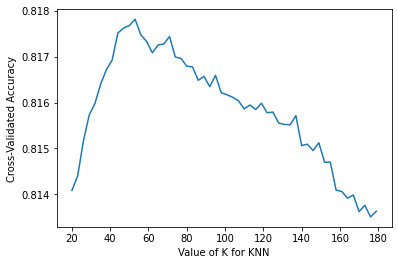

In [77]:
print(f"Training accuracy {GS.score(X_train, y_train)}")
print("="*10, "Best estimator is", "="*10)
print(GS.best_estimator_)

GS_result = pd.DataFrame(GS.cv_results_)
print("="*10, "CV Acc for each K", "="*10)
print(GS_result.groupby(["param_n_neighbors"])['mean_test_score'].mean())

k_idx = GS_result.groupby(["param_n_neighbors"])['mean_test_score'].mean().index
acc = GS_result.groupby(["param_n_neighbors"])['mean_test_score'].mean().values

plt.plot(k_idx, acc)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated Accuracy')
plt.show()